__SC24219070 朱越__

# 导入库与加载数据

程序结构参考了各论坛相关例程内容，把基础RNN结构中的SimpleRNN块换成了LSTM块。

## 加载必要的库，然后使用tensorflow.keras中的工具加载数据集

In [1]:
import os
os.environ['KERAS_HOME'] = './datas/keras'  # 设置数据集路径
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [2]:
# 加载数据集
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words, seed=42)
class_names = ["Negative", "Positive"]

## 先打印一部分训练集看一下导入的情况

In [3]:
# 获取单词到整数的映射字典
word_index = imdb.get_word_index()
# 反转字典（整数 -> 单词）
word_list = {v: k for k, v in word_index.items()}
# 将整数序列解码为文本（注意索引偏移 3：0=padding，1=start，2=unknown）
decoded_review = ' '.join([word_list.get(i - 3, '?') for i in train_data[0]])
print("训练样本数:", len(train_data))  # 输出: 25000
print("测试样本数:", len(test_data))   # 输出: 25000
print("第一条评论的整数序列:", train_data[0][:500])
print("第一条评论的文本内容:", decoded_review[:500])
print("第一条评论的标签:", class_names[train_labels[0]])  # 0 或 1

训练样本数: 25000
测试样本数: 25000
第一条评论的整数序列: [1, 11, 4079, 11, 4, 1986, 745, 3304, 299, 1206, 590, 3029, 1042, 37, 47, 27, 1269, 2, 7637, 19, 6, 3586, 15, 1367, 3196, 17, 1002, 723, 1768, 2887, 757, 46, 4, 232, 1131, 39, 107, 3589, 11, 4, 4539, 198, 24, 4, 1834, 133, 4, 107, 7, 98, 413, 8911, 5835, 11, 35, 781, 8, 169, 4, 2179, 5, 259, 334, 3773, 8, 4, 3497, 10, 10, 17, 16, 3381, 46, 34, 101, 612, 7, 84, 18, 49, 282, 167, 2, 7173, 122, 24, 1414, 8, 177, 4, 392, 531, 19, 259, 15, 934, 40, 507, 39, 2, 260, 77, 8, 162, 5097, 121, 4, 65, 304, 273, 13, 70, 1276, 2, 8, 15, 745, 3304, 5, 27, 322, 2197, 2, 2, 70, 30, 2, 88, 17, 6, 3029, 1042, 29, 100, 30, 4943, 50, 21, 18, 148, 15, 26, 5980, 12, 152, 157, 10, 10, 21, 19, 3196, 46, 50, 5, 4, 1636, 112, 828, 6, 1003, 4, 162, 5097, 2, 517, 6, 2, 7, 4, 9527, 5593, 4, 351, 232, 385, 125, 6, 1693, 39, 2383, 5, 29, 69, 5593, 5670, 6, 162, 5097, 1567, 232, 256, 34, 718, 5612, 2980, 8, 6, 226, 762, 7, 2, 7830, 5, 517, 2, 6, 3242, 7, 4, 351, 232, 37, 9, 1861, 

可以看到数据集已经正确导入了。

另外，因为keras中导入的imdb库已经执行了文本的预处理——它将数据集中出现的单词根据词频排序并编码——因此不需要再执行文本处理了。

## 定义了训练中用到的变量、定义了网络结构、损失函数和优化方法

在训练前需要先对文本切片和标准化。

网络搭建和优化方法、损失函数、评价指标都使用了tensorflow.keras库中的集成方法。

感觉仿佛什么都没做，但是已经做完了，哈哈！

In [4]:
epochs = 20
batch_size = 128
sequences_len = 500

# 将序列填充/截断为固定长度（例如 500 单词）
train_sequences = sequence.pad_sequences(train_data, maxlen=sequences_len)
test_sequences = sequence.pad_sequences(test_data, maxlen=sequences_len)
model = Sequential([
    # 嵌入层：将整数索引映射为 32 维向量
    Embedding(input_dim=num_words, output_dim=32),
    # LSTM 层：32 个隐藏单元
    LSTM(32, dropout=0.2, recurrent_dropout=0.2),  # 使用 LSTM 单元
    # 输出层：二分类（sigmoid）
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

打印网络的情况观察一下。

In [5]:
model.build(input_shape=(batch_size, sequences_len))  # (batch_size, sequence_length)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (128, 500, 32)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (128, 32)                   │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (128, 1)                    │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 328,353 (1.25 MB)

 Trainable params: 328,353 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

# 开始炼！
训练也只有一句啊！

In [6]:
history = model.fit(train_sequences, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 70s 427ms/step - accuracy: 0.5692 - loss: 0.6798 - val_accuracy: 0.7746 - val_loss: 0.5147
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 409ms/step - accuracy: 0.7751 - loss: 0.4957 - val_accuracy: 0.8338 - val_loss: 0.3933
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 427ms/step - accuracy: 0.8337 - loss: 0.3945 - val_accuracy: 0.8132 - val_loss: 0.4114
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 69s 437ms/step - accuracy: 0.8574 - loss: 0.3514 - val_accuracy: 0.8130 - val_loss: 0.4125
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 471ms/step - accuracy: 0.8811 - loss: 0.3080 - val_accuracy: 0.8182 - val_loss: 0.4064
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 69s 440ms/step - accuracy: 0.8869 - loss: 0.2913 - val_accuracy: 0.8546 - val_loss: 0.3467
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 69s 437ms/step - accuracy: 0.9012 - loss: 0.2617 - val_accuracy: 0.8386 - val_loss: 0.3677
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 69s 439ms/step - accuracy: 0.8999 - loss: 0

# 训练结果与后处理
## 网络损失和分类正确率的可视化

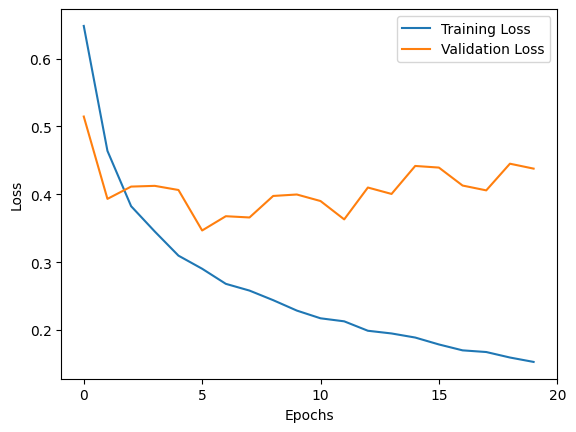

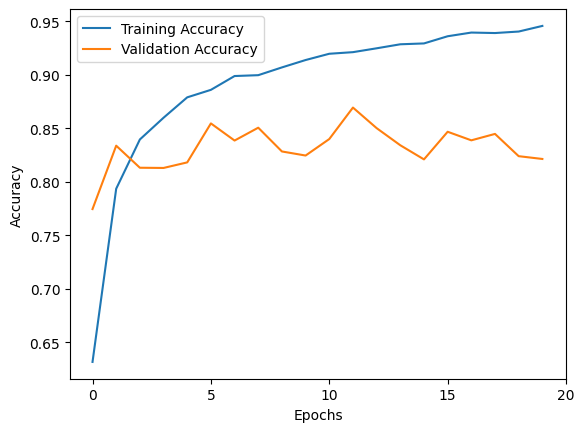

In [7]:
# 绘制训练集和验证集的损失
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.xticks(range(0, epochs+1, 5))
plt.ylabel('Loss')
plt.legend()
plt.show()
# 绘制训练集和验证集的准确率
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks(range(0, epochs+1, 5))
plt.ylabel('Accuracy')
plt.legend()
plt.show()

根据曲线可以看出，网络在5次训练左右的验证集Loss值进入一个低谷。

后续的训练只有train_acc升高而val_acc不升高，表示开始进入过拟合。

不过RNN网络的训练总体来说没有CNN平稳，当训练次数达到10以上时还出现了非常明显的振荡。

## 抽样检查识别结果

In [8]:
# 1. 抽取 10 个样本
#因为导入训练集时已经随机提取了，所以这里就不随机了。
indices = list(range(11, 21))
sampled_sequences = train_sequences[indices]
sampled_labels = train_labels[indices]
# 2. 使用模型预测
predictions = model.predict(sampled_sequences)
predicted_classes = (predictions > 0.5).astype(int)  # 二分类：sigmoid输出转0/1
# 3. 打印对比结果
for i in range(len(indices)):
    true_label = class_names[sampled_labels[i]]
    pred_label = class_names[predicted_classes[i][0]]
    print(f"Index: {indices[i]}, True Label: {true_label}, Predicted Label: {pred_label} ({predictions[i][0]:.4f})")  # 同时输出原始概率值

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
Index: 11, True Label: Positive, Predicted Label: Positive (0.9987)
Index: 12, True Label: Positive, Predicted Label: Positive (0.9991)
Index: 13, True Label: Negative, Predicted Label: Negative (0.0054)
Index: 14, True Label: Positive, Predicted Label: Positive (0.9974)
Index: 15, True Label: Negative, Predicted Label: Negative (0.0241)
Index: 16, True Label: Negative, Predicted Label: Negative (0.0763)
Index: 17, True Label: Negative, Predicted Label: Negative (0.4817)
Index: 18, True Label: Positive, Predicted Label: Positive (0.9981)
Index: 19, True Label: Positive, Predicted Label: Positive (0.9797)
Index: 20, True Label: Positive, Predicted Label: Positive (0.9268)


可以看到，基本所有的样本都正确识别了，而且原始概率值的区分度也比较大（置信度较高）。

## 保存模型、统计准确率

- 执行了一次保存和载入。

- 怎么评价也只有一句！

In [9]:
model.save('./models/HW3_RNN.keras')  # 保存为 keras 格式

In [10]:
# 评估测试集
net = load_model('./models/HW3_RNN.keras')  # 加载 keras 文件
test_loss, test_acc = net.evaluate(test_sequences, test_labels)
print(f"Test Accuracy: {test_acc:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 75ms/step - accuracy: 0.8417 - loss: 0.4078
Test Accuracy: 0.8372


根据得到的结果可以看出，网络在测试集上的准确率达到了83.72，已经属于单层LSTM不错的水平了！

# 总结与反思

- 本次实验使用了一个Sequential结构的简单RNN模型，使用了LSTM块作为隐藏层单元，实现了85%左右的分类准确率。

- 感觉这个RNN网络训练比Alexnet快多了，准确率也高不少，可能是二分类任务更容易一些叭！